# Philadelphia's Urban Tree Canopy and Heat Disparity

### Like many densely populated cities, Philadelphia experiences the urban heat island effect, seeing elevated air and surface temperatures compared to surrounding areas with less dense population and increased green space. In recent years, the city has faced increasingly warm summers which has intensified heat-related discomfort for residents. One effective strategy to cooling in urban areas addition of trees, which can reduce air and surface temperature by providing shade and blocking sunlight.

### This project analyzes spatial patterns of surface temperature, tree planting distribution, and socioeconomic factors across Philadelphia census tracts to identify areas most in need of urban greenspace initiatives in order to reduce heat.

In [1]:
# Read in libraries for use in the script
import rasterio
import rasterio.plot
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### The following datasets are used in the analysis:
### PASDA - Philadelphia Tree Inventory
### PASDA - Philadelphia Census Tracts
### American Community Survey (ACS) - Median Household Income
### LANDSAT Collection 2 - Surface Temperature

## Import and Clean Datasets

## Landsat Surface Temperature

In [2]:
# Read in landsat imagery for surface temperature data
raster_path = (
    "LC08_CU_028008_20240903_20240909_02_ST_B10.TIF"
)
src = rasterio.open(raster_path)
print(src)

<open DatasetReader name='LC08_CU_028008_20240903_20240909_02_ST_B10.TIF' mode='r'>


In [3]:
# Transform the parameters on map from pixel to real space
src.transform

Affine(30.0, 0.0, 1634415.0,
       0.0, -30.0, 2114805.0)

In [4]:
affine= src.transform

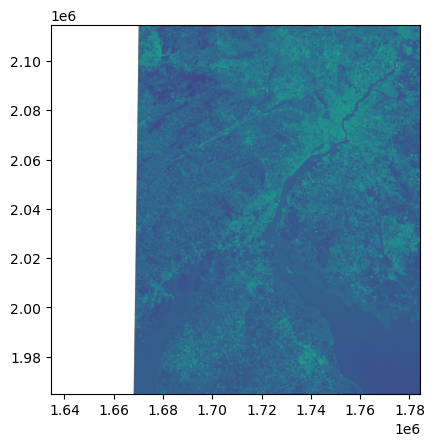

<Axes: >

In [5]:
# Show the raw image
rasterio.plot.show(src)

### The image shows Philadelphia and the surrounding areas of Pennsylvania and South New Jersey. Zooming in and adding the municipal boundary for Philadelphia will help us visualize temperature changes within the city.

In [6]:
# Read image bands for surface temperature
data = src.read(1)

In [7]:
# Apply the scaling factor to convert data to temperature in Kelvin
temperature_kelvin = (data * 0.00341802) + 149.0

# Convert Kelvin to Fahrenheit
temperature = ((temperature_kelvin - 273.15) * 9/5 + 32)


In [8]:
# exclude values outside of study area
temperature_kelvin[temperature_kelvin < 265] = np.nan
temperature[temperature < 20] = np.nan



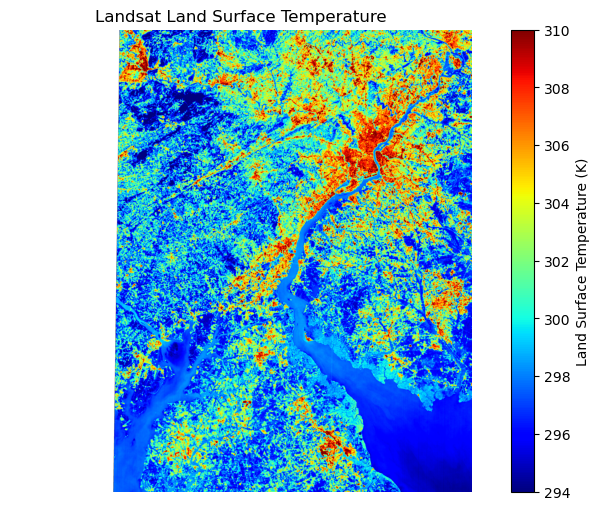

In [9]:
# Plot the temperature map (K)
plt.figure(figsize=(10, 6))
plt.imshow(temperature_kelvin, cmap='jet', vmin=294, vmax=310)
plt.colorbar(label='Land Surface Temperature (K)')
plt.title('Landsat Land Surface Temperature')
plt.axis('off')
plt.show()

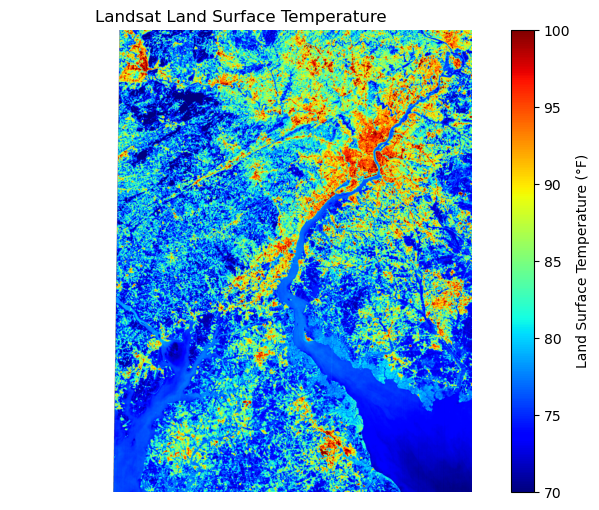

In [10]:
# Plot the temperature map (F)
plt.figure(figsize=(10, 6))
plt.imshow(temperature, cmap='jet', vmin= 70, vmax= 100)
plt.colorbar(label='Land Surface Temperature (°F)')
plt.title('Landsat Land Surface Temperature')
plt.axis('off')
plt.show()

### Temperatures appear to much warmer in the Philadelphia urban area and cooler in surrounding suburbs.

## Philadelphia Census Tracts

In [11]:
# Read in census tract boundary layer
dem_bounds = (
    "./Philadelphia_Census_Tracts_2020.geojson"
)
dem_bounds_gdf = gpd.read_file(dem_bounds)

In [12]:
# standardize coordinate reference system of layers
dem_bounds_gdf.crs
dem_bounds_gdf = dem_bounds_gdf.to_crs(src.crs)

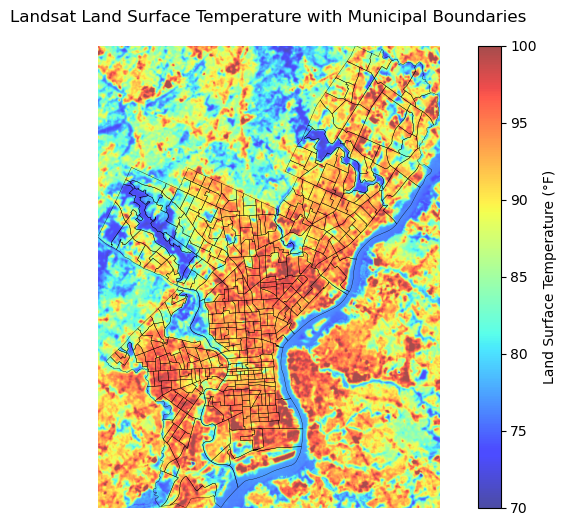

In [13]:
# The extent of the data
landsat_extent = [
    src.bounds.left,
    src.bounds.right,
    src.bounds.bottom,
    src.bounds.top
]

# Plot the temperature map
fig, ax = plt.subplots(figsize=(10, 6))

img = ax.imshow(temperature, extent=landsat_extent, cmap='jet', vmin=70, vmax=100, alpha=.7)

# Overlay the municipal boundaries
dem_bounds_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=.25)

# Add colorbar
cbar = plt.colorbar(img, ax=ax, label='Land Surface Temperature (°F)')

# Add title
ax.set_title('Landsat Land Surface Temperature with Municipal Boundaries')
ax.axis('off')

# Adjust the plot bounds to your study area
ax.set_xlim(dem_bounds_gdf.total_bounds[0], dem_bounds_gdf.total_bounds[2])
ax.set_ylim(dem_bounds_gdf.total_bounds[1], dem_bounds_gdf.total_bounds[3])

# Adjust margins
plt.margins(x=0, y=0)

plt.show()


### Temperatures appear warm in urban area of Philadelphia, cooling down in green areas like Fairmount Park and cooling in surrounding parts of Pennsylvania outside of the city boundary.

## Tree Inventory Data

In [14]:
# Read in tree inventory data
tree_canopy_path = 'ppr_tree_inventory_2024.geojson'
tree_canopy = gpd.read_file(tree_canopy_path)

# Standardize coordinate reference system to match other layers
tree_canopy = tree_canopy.to_crs(src.crs)   

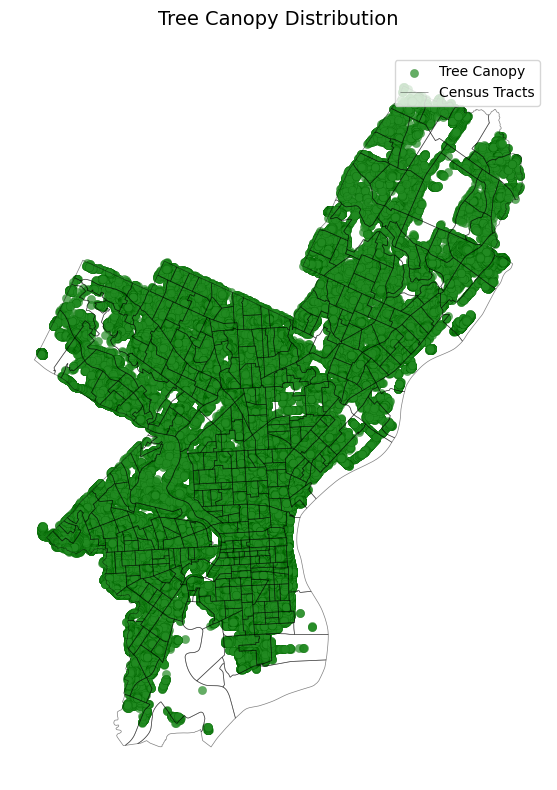

In [15]:
# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Style the plot
tree_canopy.plot(ax=ax,
                 color='forestgreen',
                 alpha=0.7,
                 label='Tree Canopy',
                 edgecolor='darkgreen',
                 linewidth=0.2)

# Add census tract boundaries
dem_bounds_gdf.boundary.plot(ax=ax,
                           color='black',
                           linewidth=0.5,
                           linestyle='solid',
                           alpha=0.5,
                           label='Census Tracts')

# Custimize title and legend location
plt.title('Tree Canopy Distribution', pad=20, fontsize=14)
ax.axis('off')
plt.legend(loc='upper right')

# Add tight layout
plt.tight_layout()

# Show the plot
plt.show()


### The raw data is not the best visual aid for showing where there are fewer or more trees because point data appears stacked on top of each other. Calculating the number of trees later in the analysis will help us to visualize which census tracts have mroe planted trees.

## Median Household Income

### Median household income from the ACS appears in the table with the field name 'SE_A14006_001"

In [16]:
# Read the CSV 
census = pd.read_csv('med_household_tracts.csv')

# Replace empty strings with 0
census['SE_A14006_001'] = census['SE_A14006_001'].replace('', '0')

# Convert the column to numeric type
census['SE_A14006_001'] = pd.to_numeric(census['SE_A14006_001'], errors='coerce')

census['SE_A14006_001'] = census['SE_A14006_001'].fillna(0)

# Convert to integer
census['SE_A14006_001'] = census['SE_A14006_001'].astype(int)

## Calculate Values of Interest

### Calculating values for each of our variables at the census tract level will allow us to visualize values grouped at a smaller level.

In [17]:
# Calculate mean surface temperature for each census tract
from rasterstats import zonal_stats

# Use zonal_stats on the temperature array

stats = zonal_stats(
    dem_bounds_gdf,             # Census tract polygons
    temperature,            # Surface temperature array
    affine=affine,       # the raster transform (pixel to coordinates)
    stats=["mean"],         # calculate mean surface temperature
    nodata=np.nan           # treat missing values as no data
)

# Add the results to the tracts layer table
dem_bounds_gdf['mean_temperature'] = [s['mean'] for s in stats]


In [18]:
# Join trees to Phila boundary
join_left_df = dem_bounds_gdf.sjoin(tree_canopy, how="left")

In [19]:
# Join layers by census tract id  
join_left_df['GEOID'] = join_left_df['GEOID'].astype(int)


In [20]:
# join census to joined table we created
phila_data = join_left_df.merge(census, left_on="GEOID", right_on="Geo_FIPS", how="left")

In [21]:
# Calculate tree counts by adding repetitions of each census tract id in table
tree_count = phila_data['GEOID'].value_counts()

In [22]:
# Join tract counts to table by census tract id
phila_data['tree_count'] = phila_data['GEOID'].map(tree_count.to_dict())

## Plot Calculated Values

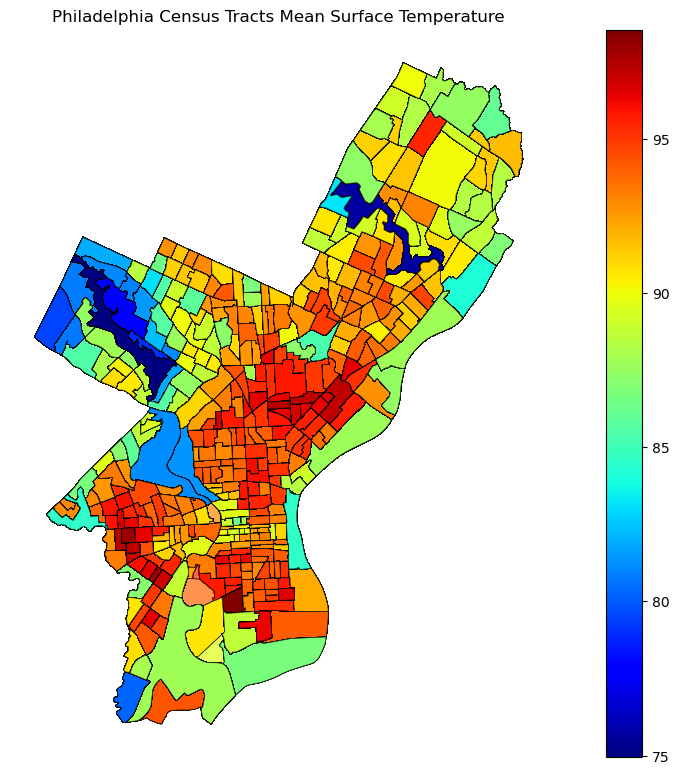

In [23]:
# Plot mean surface temperature by tracts
fig, ax = plt.subplots(figsize=(12, 8))



# Plot with color based on a mean surface temp
phila_data.plot(column='mean_temperature', 
                ax=ax,
                legend=True,
                cmap='jet',      
                edgecolor='black',
                linewidth=0.5,
                alpha=0.7)

# Customize the plot
plt.title('Philadelphia Census Tracts Mean Surface Temperature')
ax.axis('off')

# Add tight layout
plt.tight_layout()

# Show the plot
plt.show()

### There appears to be higher mean surface temperatures clustered in the central area of the city and spreading to the south and southwest areas of Philadelphia.

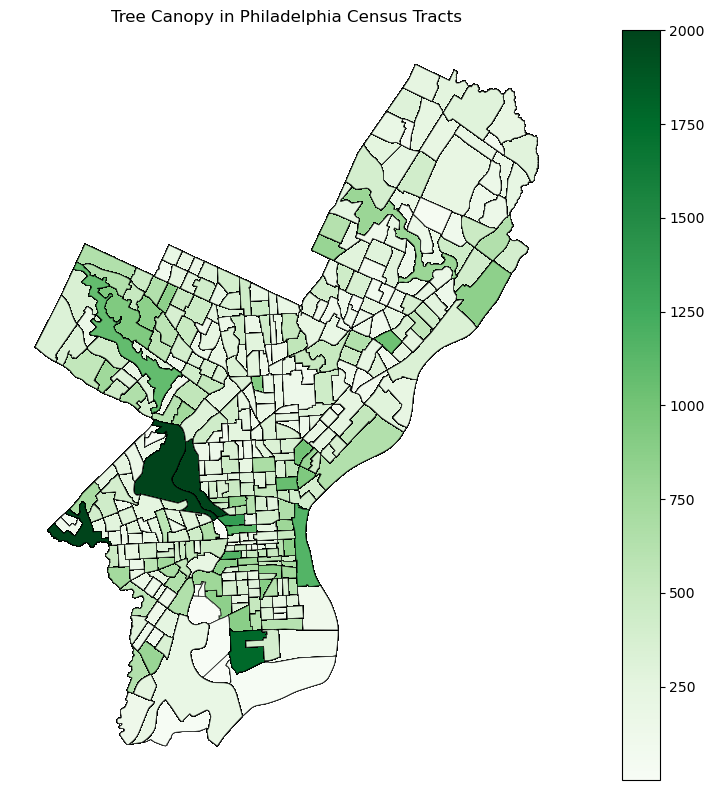

In [24]:
# Plot tree amounts by census tracts

fig, ax = plt.subplots(figsize=(12, 8))



# Plot with color based on a tree counts
phila_data.plot(column='tree_count',
                vmax=2000, 
                ax=ax,
                legend=True,
                cmap='Greens',      
                edgecolor='black',
                linewidth=0.5,
                alpha=0.7)

# Customize the plot
plt.title('Tree Canopy in Philadelphia Census Tracts')
ax.axis('off')

# Add tight layout
plt.tight_layout()

# Show the plot
plt.show()

### Fairmount Park has significantly more trees than other areas of Philadelphia as expected.

### We can see that the central area of the city has fewer trees than the surrounding census tracts.

### When comparing these plots, cooler areas appear to have a higher amount of trees.

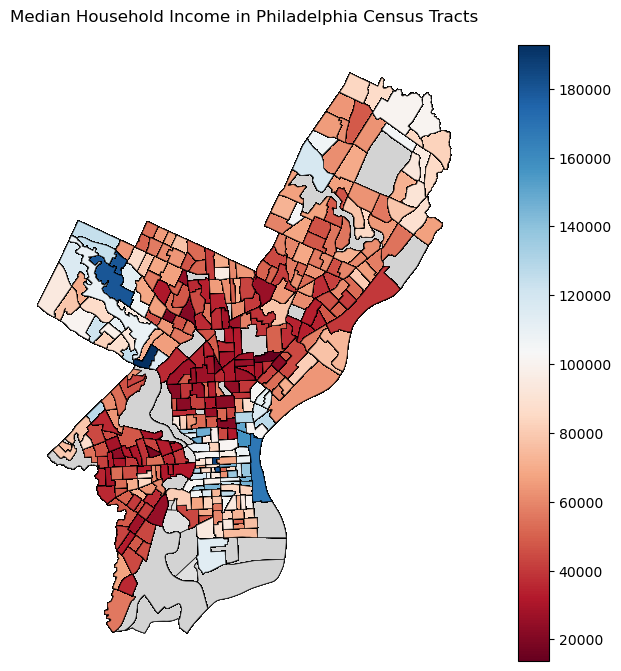

In [25]:
# Plot median household income by census tract, ignoring non-residential

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the zero-income areas first in grey
phila_data[phila_data['SE_A14006_001'] == 0].plot(
    ax=ax,
    color='lightgrey',    # or just 'grey'
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
)

# Then plot the non-zero income areas with the color map
phila_data[phila_data['SE_A14006_001'] > 0].plot(
    column='SE_A14006_001',
    ax=ax,
    legend=True,
    cmap='RdBu',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
)

# Customize the plot
plt.title('Median Household Income in Philadelphia Census Tracts')
ax.axis('off')

# Show the plot
plt.show()


### Low income areas appear to be clustered in the northern central area of the city. Areas like Fairmount Park and Navy Yard where there are not residents appear on the map as grey to indicate no median income recorded.

In [26]:
# Combine all values and select priority areas for tree planting
# Mean surface temp - 'mean_temperature'
# Tree inventory - 'tree_count'
# Median household income - 'SE_A14006_001' 


# First, compute thresholds
temp_thresh = phila_data['mean_temperature'].quantile(0.25)  # top 25% hottest
tree_thresh = phila_data['tree_count'].quantile(0.25)        # bottom 25% tree counts
income_thresh = phila_data['SE_A14006_001'].quantile(0.5)    # bottom 50% income
# print(income_thresh)
# print(tree_thresh)
# Create a new column: priority_area
phila_data['priority_area'] = (
    (phila_data['mean_temperature'] >= temp_thresh) &
    (phila_data['tree_count'] <= tree_thresh) &
    (phila_data['SE_A14006_001'] <= income_thresh) &
    (phila_data['SE_A14006_001'] > 0)                       # ignore non-residential areas 
)


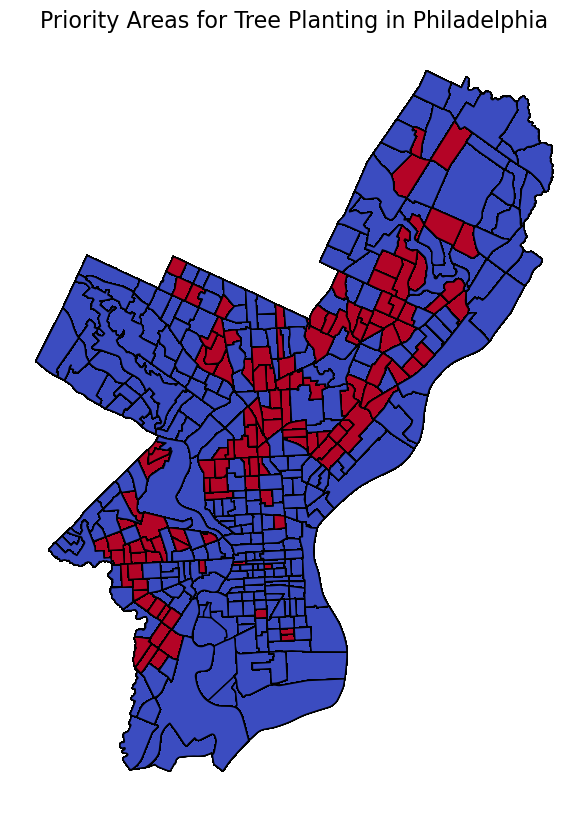

In [27]:
# Plot results - priority tracts for tree planting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
phila_data.plot(column='priority_area', cmap='coolwarm', ax=ax, edgecolor='black')
ax.set_title('Priority Areas for Tree Planting in Philadelphia', fontsize=16)
plt.axis('off')
plt.show()


# Conclusion

### Several Philadelphia census tracts were able to be identified as priority planting areas based on low income status, low relative tree canopy, and high relative surface temperatures.

### Several neighborhoods in the northern central area of the city were pinpointed as areas where residents could benefit from tree planting or other green space initiatives to cool the air and surface temperatures. The priority planting map appears to align with the median household income map, suggesting that low income communities suffer more from increased heat in the warmer months of the year due to a lack of tree canopy to provde shade.

# Future Improvements

### Future improvements to the analysis could include normalization of the datasets by population to consider areas with more residents. Additionally, addition of other environmental factors like air quality or demographic data like education status or race could be used to improve the analysis and more preciusely target disadvantaged naighborhoods in our city.

# Moving Forward

### Future analyses could explore the potential impact of increased tree canopy on reducing urban heat islands in the identified areas. 

### Researchers could model how tree planting might improve air quality, public health outcomes, and property values over time. Studies focused on environmental justice and equity could assess whether investments in these areas would help close environmental justice gaps compared to more affluent neighborhoods. 

### Perhaps a cost-benefit analysis could be conducted to prioritize specific tracts where planting initiatives would yield the greatest combined social, environmental, and economic benefits.